# Manifold learning on handwritten digits: Locally Linear Embedding, Isomap…#



In [1]:
from sklearn.datasets import load_digits

digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
n_neighbors = 30

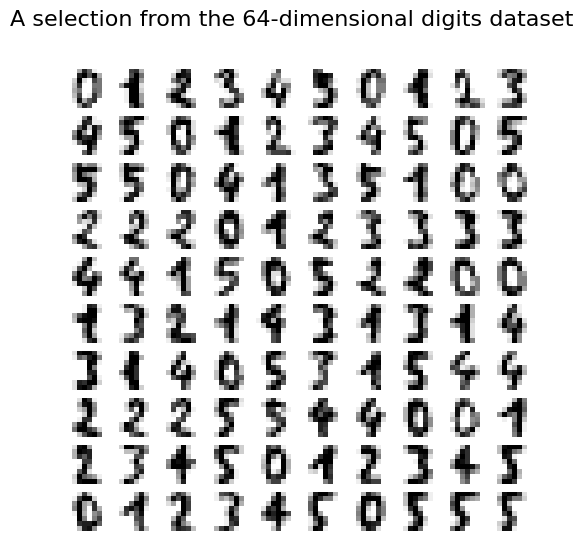

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

In [3]:
import numpy as np
from matplotlib import offsetbox

from sklearn.preprocessing import MinMaxScaler


def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

**Embedding techniques comparison**

Below, we compare different techniques. However, there are a couple of things to note:

- the RandomTreesEmbedding is not technically a manifold embedding method, as it learn a high-dimensional representation on which we apply a dimensionality reduction method. However, it is often useful to cast a dataset into a representation in which the classes are linearly-separable.
- the LinearDiscriminantAnalysis and the NeighborhoodComponentsAnalysis, are supervised dimensionality reduction method, i.e. they make use of the provided labels, contrary to other methods.
- the TSNE is initialized with the embedding that is generated by PCA in this example. It ensures global stability of the embedding, i.e., the embedding does not depend on random initialization.

In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    MDS,
    TSNE,
    Isomap,
    LocallyLinearEmbedding,
    SpectralEmbedding,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection

embeddings = {
    "Random projection embedding": SparseRandomProjection(
        n_components=2, random_state=42
    ),
    "Truncated SVD embedding": TruncatedSVD(n_components=2),
    "Linear Discriminant Analysis embedding": LinearDiscriminantAnalysis(
        n_components=2
    ),
    "Isomap embedding": Isomap(n_neighbors=n_neighbors, n_components=2),
    "Standard LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="standard"
    ),
    "Modified LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="modified"
    ),
    "Hessian LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="hessian"
    ),
    "LTSA LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="ltsa"
    ),
    "MDS embedding": MDS(n_components=2, n_init=1, max_iter=120, n_jobs=2),
    "Random Trees embedding": make_pipeline(
        RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0),
        TruncatedSVD(n_components=2),
    ),
    "Spectral embedding": SpectralEmbedding(
        n_components=2, random_state=0, eigen_solver="arpack"
    ),
    "t-SNE embedding": TSNE(
        n_components=2,
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    ),
    "NCA embedding": NeighborhoodComponentsAnalysis(
        n_components=2, init="pca", random_state=0
    ),
}

In [7]:
from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = X.copy()
        data.flat[:: X.shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = X

    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(data, y)
    timing[name] = time() - start_time

Computing Random projection embedding...
Computing Truncated SVD embedding...
Computing Linear Discriminant Analysis embedding...
Computing Isomap embedding...
Computing Standard LLE embedding...
Computing Modified LLE embedding...
Computing Hessian LLE embedding...
Computing LTSA LLE embedding...
Computing MDS embedding...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Computing Random Trees embedding...
Computing Spectral embedding...
Computing t-SNE embedding...
Computing NCA embedding...


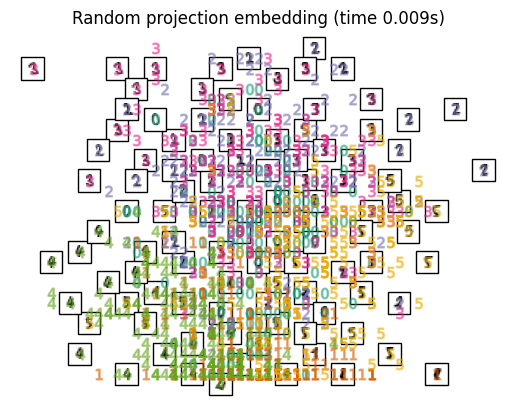

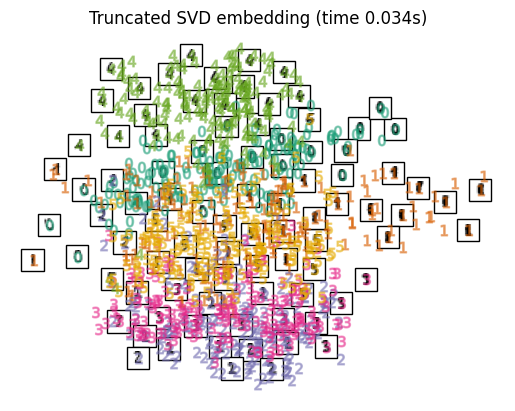

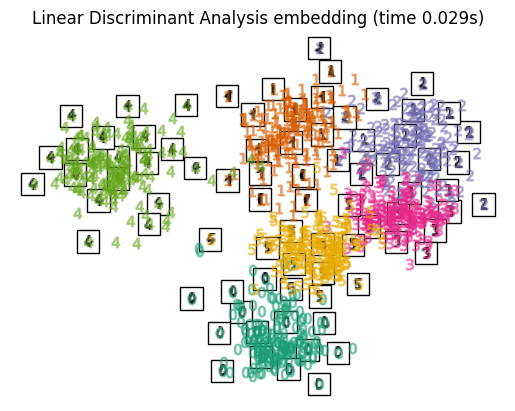

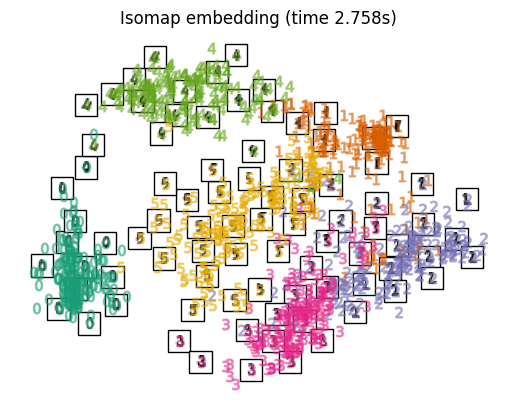

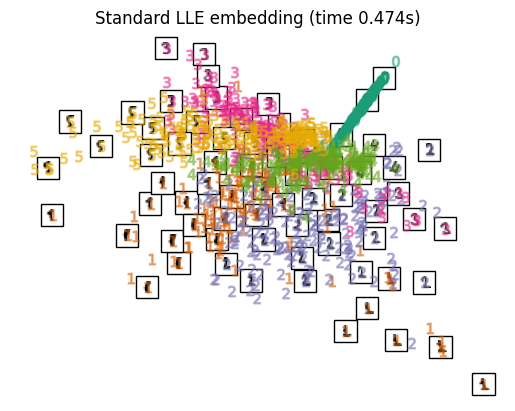

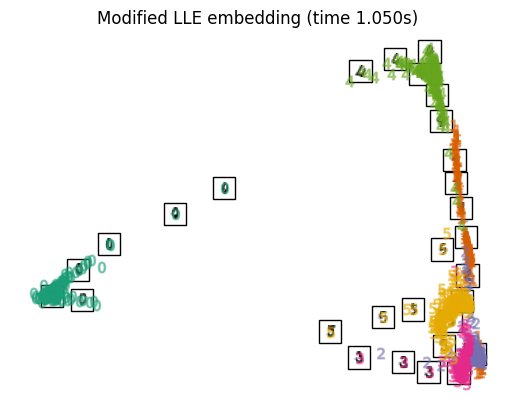

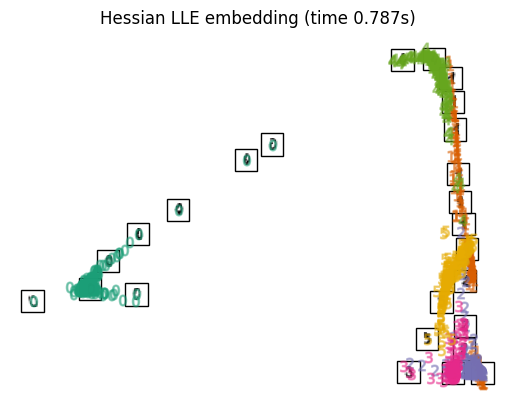

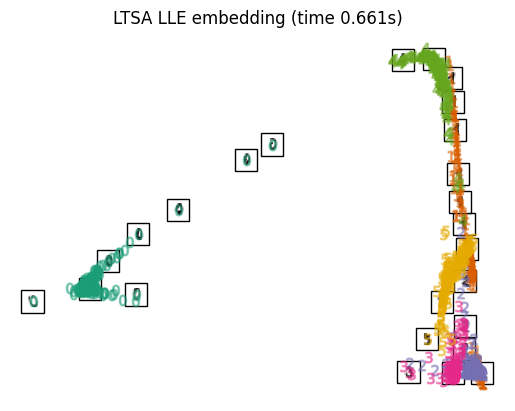

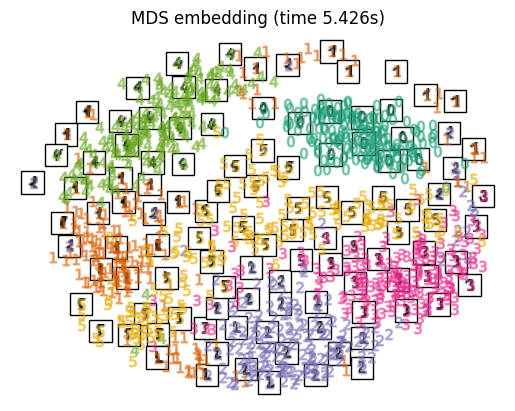

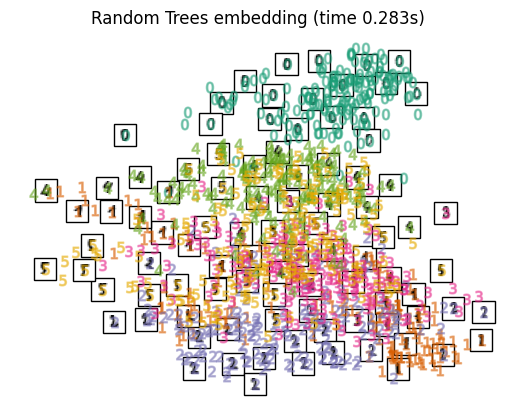

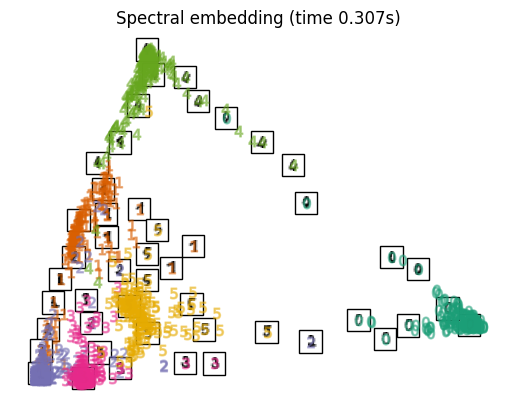

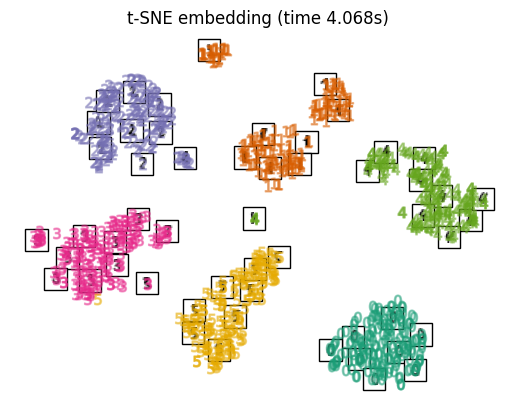

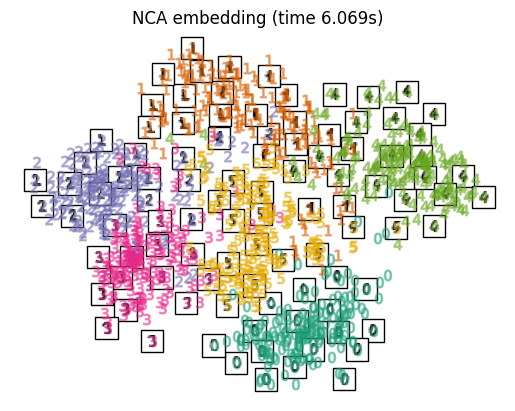

In [8]:
for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title)

plt.show()